
# 1. OpenAI VLM (GPT-4*) - Basics
This section demonstrates the basic usage of OpenAI's Vision Language Model (VLM) capabilities using GPT-4.
We will use the OpenAI API to analyze an image and provide detailed textual insights.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation 
- https://platform.openai.com/docs/guides/vision?lang=node
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=image 
- https://platform.openai.com/docs/api-reference/chat


#### Einleitung in die Verarbeitung von Bildern mit Vision Language Models (VLMs)

In diesem Code werden die Grundlagen zur Verarbeitung von Bildern in Kombination mit Text gelegt. Wir importieren die benötigten Bibliotheken, laden Umgebungsvariablen wie den API-Schlüssel und definieren Funktionen zur Bildkodierung. Mit diesen Vorbereitungen können wir später ein Modell verwenden, das sowohl Bild- als auch Textinformationen verarbeitet, wie GPT-4 mit visueller Komponente.

In [17]:
import openai
from dotenv import load_dotenv  
import os # Ermöglicht den Zugriff auf Betriebssystemfunktionen,
import base64
import json
import textwrap

# Funktion zur Kodierung eines Bildes in Base64-Format, um es an das Modell zu senden
def encode_image(image_path):
  with open(image_path, "rb") as image_file:  # Öffnet das Bild im Binärmodus
      return base64.b64encode(image_file.read()).decode('utf-8')  # Kodiert die Binärdaten und wandelt sie in einen String um

# Lädt Umgebungsvariablen aus der .env-Datei
load_dotenv()

# Initialisiert den OpenAI-Client mit dem API-Schlüssel aus den Umgebungsvariablen
# Dies ermöglicht die Kommunikation mit GPT-4 oder anderen OpenAI-Modellen
openAIclient = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


# Definiert Text- und Bildmodelle, die später verwendet werden
TEXTMODEL = "gpt-4o-mini"  # Name des Modells für Textverarbeitung
IMGMODEL = "gpt-4o-mini"   # Name des Modells für Bildverarbeitung

# Pfad zu einem Beispielbild, das verarbeitet werden soll
img = "images/street_scene.jpg"

#### Grundlegende Anfrage an GPT-4 mit einem Prompt und einem Bild
In diesem Code wird eine Anfrage an GPT-4 gestellt, bei der sowohl Text (eine Frage) als auch ein Bild als Eingabe verwendet werden. Das Bild wird im Base64-Format kodiert und an das Modell gesendet. Die Ausgabe des Modells wird strukturiert zurückgegeben und formatiert, um sie leserfreundlich anzuzeigen. Dieser Abschnitt demonstriert, wie multimodale Modelle Bild- und Textinformationen kombinieren können.

Wenn ich ein Text, anstatt ein bild ansteuern woltle:
Wenn du den Code so ändern möchtest, dass anstelle eines Bildes nur ein Text an das Modell gesendet wird, entfernst du die Bild-Komponente und gibst lediglich den Text als Eingabe an. Hier ist der angepasste Code:

```python
# Geänderter Code für eine Textabfrage
# Basisaufruf an GPT-4 nur mit einem Textprompt

completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",  # Das Modell, das verwendet wird
    messages=[
        {
            "role": "user",  # Rolle des Benutzers, der die Anfrage stellt
            "content": "Describe the benefits of Vision Language Models.",  # Textprompt
        }
    ],
)

# Formatierung und Ausgabe der Modellantwort

# Konvertiert die erste Antwort aus den Modellantworten in eine String-Darstellung
response = str(completion.choices[0].message)

# Gibt die Antwort formatiert aus, um sie besser lesbar zu machen
print(textwrap.fill(response, width=120))  # Wrappt die Textausgabe auf eine Breite von 120 Zeichen
```
1. **Entfernen der Bildkomponente**:
   - Die `"image_url"`-Sektion wurde entfernt, da kein Bild benötigt wird.
   - Nur der Textprompt wird als Eingabe an das Modell gesendet.

2. **Anpassung des Prompts**:
   - Statt der Frage zum Bild (`"What's in this image?"`) wird ein anderer, rein textbezogener Prompt verwendet (`"Describe the benefits of Vision Language Models."`).

3. **Einfache Textausgabe**:
   - Die Antwort wird unverändert wie zuvor formatiert und angezeigt.

Man kann jedes Bild in das Base64-Format umwandeln, unabhängig vom Bildtyp oder der Dateigröße, solange das Format unterstützt wird (z. B. .jpg, .png, .gif, etc.) und genügend Speicherplatz sowie Ressourcen vorhanden sind.

In [18]:
# Basisaufruf an GPT-4 mit einem Text-Prompt und einem Bild

# Sendet eine Anfrage an das GPT-4-Modell mit Bild- und Textinformationen
completion = openAIclient.chat.completions.create(
    model="gpt-4o-mini",  # Das Modell, das für die Analyse verwendet wird
    messages=[
        {
            "role": "user",  # Definiert die Rolle (in diesem Fall der Benutzer, der die Anfrage stellt)
            "content": [  # Die Eingabeinhalte, die das Modell verarbeiten soll
                {"type": "text", "text": "What's in this image?"},  # Textprompt mit einer Frage
                {
                    "type": "image_url",  # Bild als Eingabetyp
                    "image_url": {  # Eingabebild in Base64-kodiertem Format
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",  # Kodiertes Bild wird hier eingebettet (pfad ist im oberen Codeteil)
                        # "detail": "low"  # (Optional) Kann genutzt werden, um Details oder Auflösung zu steuern
                    }
                },
            ],
        }
    ],
)

# Formatierung und Ausgabe der Modellantwort

# Konvertiert die erste Antwort aus den Modellantworten in eine String-Darstellung
response = str(completion.choices[0].message)

# Gibt die Antwort formatiert aus, um sie besser lesbar zu machen
print(textwrap.fill(response, width=120))  # Wrappt die Textausgabe auf eine Breite von 120 Zeichen


ChatCompletionMessage(content='The image depicts a busy urban street scene. In the foreground, there are pedestrians,
including a boy sitting on the ground looking at a device, and another individual lying on the pavement. A woman is
reading on a nearby bench, while another woman walks by with her phone. There are several pigeons scattered around, and
a few vehicles are seen in the street, along with a cyclist and a person playing guitar. The backdrop features buildings
typical of a cityscape, with a traffic light and trees lining the street. The overall scene conveys a blend of daily
life and city activity.', role='assistant', function_call=None, tool_calls=None, refusal=None)



# 1.1 Structured Output
Here, we expand upon the VLM example to request structured outputs. This approach allows for extracting 
well-organized information from images in a machine-readable format, such as JSON.

**Support Material**:
- https://platform.openai.com/docs/guides/text-generation?text-generation-quickstart-example=json

#### Funktion `promptLLM` – Flexible Kommunikation mit einem Language Model
Diese Funktion ermöglicht es, ein Language Model (z. B. GPT-4) mit Text und optionalen Bildern zu befragen. Sie bietet folgende Funktionen:
- Übergabe eines Text-Prompts und eines systemseitigen Prompts (Sysprompt).
- Möglichkeit, ein Bild in die Anfrage einzubetten.
- Option, die Antwort im JSON-Format zu erzwingen.
- Möglichkeit, die Antwort als Python-Dictionary (falls JSON-Antwort gewünscht) oder als einfachen Text zurückzugeben.

Die Funktion passt automatisch das verwendete Modell an (reines Textmodell oder multimodales Modell), je nachdem, ob ein Bild eingebunden wird.

**Einsatzmöglichkeiten:**
- Textanalyse: Reine Textanfragen ohne Bilder.
- Multimodale Verarbeitung: Kombination aus Text und Bild, z. B. Analyse eines Bildes mit einer spezifischen Frage.
- JSON-Ergebnisse: Strukturierte Antworten für die Weiterverarbeitung in Programmen.

In [19]:
def promptLLM(prompt: str = None, sysprompt: str = None, image: str = None, wantJson: bool = False, returnDict: bool = False):
    """
    Funktion zur flexiblen Kommunikation mit einem Language Model (z. B. GPT-4).
    
    Parameter:
    - prompt: Der Text, den der Benutzer eingibt (z. B. eine Frage).
    - sysprompt: Ein "System"-Prompt, der die Antwortstruktur des Modells steuern kann.
    - image: Ein Bild (kodiert als Base64-String), das an die Anfrage angehängt wird.
    - wantJson: Gibt an, ob die Antwort im JSON-Format zurückgegeben werden soll.
    - returnDict: Gibt an, ob die JSON-Antwort als Python-Dictionary zurückgegeben werden soll.
    
    Rückgabewert:
    - Text- oder JSON-Antwort des Modells, abhängig von den Eingabeparametern.
    """
    
    # Initialisierung der Rückgabevariable
    returnValue = ""

    # Nachrichtenliste initialisieren; beginnt mit dem System-Prompt
    messages = [{"role": "system", "content": sysprompt}]

    # Standardmäßig wird das Textmodell verwendet
    modelToUse = TEXTMODEL

    # Benutzer-Prompt wird in die Nachrichtenliste hinzugefügt
    messages.append({"role": "user", "content": [{ 
        "type": "text",  # Typ der Nachricht: Text
        "text": prompt   # Inhalt der Nachricht
    }]})

    # Falls ein Bild übergeben wird, wird es hinzugefügt
    if image is not None:
        # Bild wird in Base64-Format eingebettet
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": { "url": image }})
        # Modell wird auf das multimodale Modell umgestellt
        modelToUse = IMGMODEL

    # Wenn die Antwort als JSON-Objekt gewünscht wird
    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Gewähltes Modell
            response_format={ "type": "json_object" },  # JSON-Format erzwingen
            messages=messages,  # Nachrichtenliste
            temperature=0,  # Kontrolliert die Zufälligkeit der Antwort
        )
    else:
        # Standardmäßiger Aufruf für eine Textantwort
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Gewähltes Modell
            messages=messages,  # Nachrichtenliste
            temperature=0,  # Kontrolliert die Zufälligkeit der Antwort
        )

    # Extrahiert den Textinhalt der Antwort
    returnValue = returnValue.choices[0].message.content

    # Falls Rückgabe als Python-Dictionary gewünscht, wird die JSON-Antwort geparst
    if returnDict:
        return json.loads(returnValue)

    # Gibt die Antwort als Text oder unveränderten JSON-String zurück
    return returnValue


Dieser Code ruft die zuvor definierte Funktion promptLLM auf, um ein Bild und einen Text-Prompt an ein multimodales Modell (z. B. GPT-4) zu senden. Ziel ist es, eine detaillierte Beschreibung des Bildes zu erhalten, und zwar im JSON-Format, das in ein Python-Dictionary umgewandelt wird.

Dieser Code kombiniert Text, Bild und spezifische Antwortformate, um:
1. Eine strukturierte Analyse des Bildes zu erhalten.
2. Die Antwort leicht in Python weiterzuverarbeiten, da sie als Dictionary zurückgegeben wird.

In [20]:
output = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

In [21]:
output

{'description': {'scene': 'A bustling city street with a mix of pedestrians and vehicles.',
  'foreground': {'elements': [{'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'teen',
      'clothing': 'green jacket',
      'activity': 'using a smartphone',
      'position': 'on the ground'}},
    {'type': 'person',
     'action': 'lying down',
     'details': {'gender': 'male',
      'age': 'young adult',
      'clothing': 'red hoodie',
      'position': 'on the ground'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'female',
      'age': 'young adult',
      'clothing': 'red top',
      'activity': 'reading a book',
      'position': 'on a bench'}},
    {'type': 'person',
     'action': 'sitting',
     'details': {'gender': 'male',
      'age': 'older adult',
      'clothing': 'suit',
      'activity': 'reading a newspaper',
      'position': 'on a bench'}},
    {'type': 'person',
     'action': 'walking',
     'd

Der nachfolgende Code versucht, auf einen bestimmten Teil eines verschachtelten Python-Dictionarys namens output zuzugreifen. 

In [42]:
# Überprüfe, welche Hauptschlüssel im Dictionary output existieren:
print(output.keys())

dict_keys(['description'])


In [43]:
# Finde die Unterstruktur von description heraus:
print(output["description"].keys())

dict_keys(['scene', 'foreground', 'background', 'lighting'])


In [44]:
# Schlüssel innerhalb von foreground untersuchen
print(output["description"]["foreground"].keys())

dict_keys(['elements', 'plants', 'birds'])


In [33]:
# Zugriff auf die allgemeine Szene-Beschreibung:
scene_description = output["description"]["scene"]
print(scene_description)

A bustling city street with a mix of pedestrians and vehicles.


In [37]:
# verfügbaren Schlüssel in der "foreground"-Sektion  überprüfen:
print(output["description"]["foreground"].keys())

dict_keys(['elements', 'plants', 'birds'])


In [38]:
# Anzahl der Personen basierend auf dem Typ "person"
people_count = len([
    element for element in output["description"]["foreground"]["elements"]
    if element["type"] == "person"
])
print(f"Anzahl der Personen: {people_count}")


Anzahl der Personen: 5


In [39]:
# Extrahiere Details aller Personen in "elements"
people_details = [
    element["details"] for element in output["description"]["foreground"]["elements"]
    if element["type"] == "person"
]

# Ausgabe der Details
for i, person in enumerate(people_details, start=1):
    print(f"Person {i}: {person}")

Person 1: {'gender': 'male', 'age': 'teen', 'clothing': 'green jacket', 'activity': 'using a smartphone', 'position': 'on the ground'}
Person 2: {'gender': 'male', 'age': 'young adult', 'clothing': 'red hoodie', 'position': 'on the ground'}
Person 3: {'gender': 'female', 'age': 'young adult', 'clothing': 'red top', 'activity': 'reading a book', 'position': 'on a bench'}
Person 4: {'gender': 'male', 'age': 'older adult', 'clothing': 'suit', 'activity': 'reading a newspaper', 'position': 'on a bench'}
Person 5: {'gender': 'female', 'age': 'young adult', 'clothing': 'casual outfit', 'activity': 'using a smartphone', 'position': 'on the sidewalk'}


In [40]:
# Zugriff auf Pflanzen
plants = output["description"]["foreground"]["plants"]
print(f"Pflanzen: {plants}")


Pflanzen: {'type': 'flower pot', 'details': {'flowers': 'geraniums', 'position': 'next to the sitting boy'}}


In [41]:
# Zugriff auf Vögel
birds = output["description"]["foreground"]["birds"]
print(f"Vögel: {birds}")

Vögel: {'type': 'pigeons', 'count': 'multiple', 'position': 'around the sitting people'}


In [45]:
# Automatisierte Analyse aller Schlüssel
# Um eine komplette Übersicht über die gesamte JSON-Struktur zu erhalten, kannst du eine rekursive Funktion verwenden:
def print_keys(d, prefix=""):
    if isinstance(d, dict):
        for key in d:
            print(f"{prefix}{key}")
            print_keys(d[key], prefix + key + " -> ")
    elif isinstance(d, list):
        print(f"{prefix}[list with {len(d)} items]")
    else:
        print(f"{prefix}{type(d).__name__}")

print_keys(output)


description
description -> scene
description -> scene -> str
description -> foreground
description -> foreground -> elements
description -> foreground -> elements -> [list with 5 items]
description -> foreground -> plants
description -> foreground -> plants -> type
description -> foreground -> plants -> type -> str
description -> foreground -> plants -> details
description -> foreground -> plants -> details -> flowers
description -> foreground -> plants -> details -> flowers -> str
description -> foreground -> plants -> details -> position
description -> foreground -> plants -> details -> position -> str
description -> foreground -> birds
description -> foreground -> birds -> type
description -> foreground -> birds -> type -> str
description -> foreground -> birds -> count
description -> foreground -> birds -> count -> str
description -> foreground -> birds -> position
description -> foreground -> birds -> position -> str
description -> background
description -> background -> elements


In [22]:
output["description"]["foreground"]

{'elements': [{'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'teen',
    'clothing': 'green jacket',
    'activity': 'using a smartphone',
    'position': 'on the ground'}},
  {'type': 'person',
   'action': 'lying down',
   'details': {'gender': 'male',
    'age': 'young adult',
    'clothing': 'red hoodie',
    'position': 'on the ground'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'red top',
    'activity': 'reading a book',
    'position': 'on a bench'}},
  {'type': 'person',
   'action': 'sitting',
   'details': {'gender': 'male',
    'age': 'older adult',
    'clothing': 'suit',
    'activity': 'reading a newspaper',
    'position': 'on a bench'}},
  {'type': 'person',
   'action': 'walking',
   'details': {'gender': 'female',
    'age': 'young adult',
    'clothing': 'casual outfit',
    'activity': 'using a smartphone',
    'position': 'on the sidewalk'}}],
 


# JSON Schema for Controlled Structured Outputs
In this section, we define a JSON schema for a more controlled and specific output from the model. 
Using this schema, we can ensure the model adheres to predefined data types and structures while describing images.In this case we will provide an exmaple of json format answer, but ideally 
one could also do it via e.g. pydantic library.

Example: 
```
from typing import List, Literal
from pydantic import BaseModel, Field


class Person(BaseModel):
    position: str = Field(..., description="Position of the person in the environment, e.g., standing, sitting, etc.")
    age: int = Field(..., ge=0, description="Age of the person, must be a non-negative integer.")
    activity: str = Field(..., description="Activity the person is engaged in, e.g., reading, talking, etc.")
    gender: Literal["male", "female", "non-binary", "other", "prefer not to say"] = Field(
        ..., description="Gender of the person"
    )


class ImageExtraction(BaseModel):
    number_of_people: int = Field(..., ge=0, description="The total number of people in the environment.")
    atmosphere: str = Field(..., description="Description of the atmosphere, e.g., calm, lively, etc.")
    hour_of_the_day: int = Field(..., ge=0, le=23, description="The hour of the day in 24-hour format.")
    people: List[Person] = Field(..., description="List of people and their details.")

```

#### Funktion `promptLLM` – Flexible API-Anfrage an GPT-Modelle
Diese Funktion erstellt eine Anfrage an ein GPT-Modell mit der Option, Text, Bilder oder beides zu verarbeiten. Sie erlaubt:
- Das Erstellen von JSON-basierten Antworten durch ein definiertes Schema.
- Rückgabe der Ergebnisse als Text oder als Python-Dictionary.
- Die dynamische Auswahl zwischen einem Textmodell oder einem multimodalen Modell, je nachdem, ob ein Bild inkludiert ist.

#### Warum Text und Bild?
1. Der Text (Prompt) gibt dem Modell zusätzliche Anweisungen oder stellt spezifische Fragen, während das Bild die visuelle Grundlage für die Analyse liefert. Dies hilft dem Modell, die Anfrage präziser zu beantworten.

2. Mit einem Bild allein könnte das Modell nur eine allgemeine Analyse durchführen. Der Text-Prompt hilft jedoch, gezielte Informationen aus dem Bild zu extrahieren

3. Das Modell kann unterschiedliche Aspekte eines Bildes analysieren, je nachdem, was im Text-Prompt verlangt wird. Ohne Text ist die Antwort oft zu allgemein.

**Beispiel:**
- Prompt: "Beschreibe die Atmosphäre in diesem Bild."
- Bild: Eine Straßenaufnahme.
- Antwort: *"Die Atmosphäre ist ruhig, mit wenigen Passanten, die an einem sonnigen Nachmittag spazieren gehen."*

In [23]:
def promptLLM(prompt: str = None, sysprompt: str = None, image: str = None, wantJson: bool = False, returnDict: bool = False):
    """
    Rückgabewert: Die Antwort des Modells als Text (Standard) oder als Python-Dictionary (bei JSON).
    """
    returnValue = ""  # Initialisierung der Rückgabewert-Variable

    # Aufbau der Nachricht: System-Prompt (Hintergrundkontext für das Modell)
    messages = [{"role": "system", "content": sysprompt}]

    # Standardmäßig wird das Textmodell verwendet
    modelToUse = TEXTMODEL

    # Hinzufügen des Benutzer-Prompts zur Nachrichtenliste
    messages.append({"role": "user", "content": [{ 
        "type": "text",  # Typ der Nachricht: Text
        "text": prompt   # Inhalt des Prompts
    }]})

    # Falls ein Bild übergeben wird, füge es hinzu
    if image is not None:
        # Konvertiert das Bild in das Base64-Format für die Anfrage
        image = f"data:image/jpeg;base64,{image}"
        messages[1]["content"].append({"type": "image_url", "image_url": {"url": image}})
        # Wechsel zum multimodalen Modell
        modelToUse = IMGMODEL

    # JSON-Schema verwenden, falls wantJson=True
    if wantJson:
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Wählt das richtige Modell
            response_format={  # Definiert das JSON-Schema für die Antwort
                "type": "json_schema",
                "json_schema": {
                    "name": "img_extract",  # Name des Schemas
                    "schema": {
                        "type": "object",  # JSON-Objekt
                        "properties": {  # Erwartete Felder in der Antwort
                            "numberOfPeople": {  # Anzahl der Personen
                                "type": "integer",
                                "description": "The total number of people in the environment",
                                "minimum": 0
                            },
                            "atmosphere": {  # Beschreibung der Atmosphäre
                                "type": "string",
                                "description": "Description of the atmosphere, e.g., calm, lively, etc."
                            },
                            "hourOfTheDay": {  # Uhrzeit
                                "type": "integer",
                                "description": "The hour of the day in 24-hour format",
                                "minimum": 0,
                                "maximum": 23
                            },
                            "people": {  # Liste mit Details zu Personen
                                "type": "array",
                                "description": "List of people and their details",
                                "items": {
                                    "type": "object",
                                    "properties": {
                                        "position": {  # Position der Person
                                            "type": "string",
                                            "description": "Position of the person in the environment, e.g., standing, sitting, etc."
                                        },
                                        "age": {  # Alter der Person
                                            "type": "integer",
                                            "description": "Age of the person",
                                            "minimum": 0
                                        },
                                        "activity": {  # Aktivität der Person
                                            "type": "string",
                                            "description": "Activity the person is engaged in, e.g., reading, talking, etc."
                                        },
                                        "gender": {  # Geschlecht der Person
                                            "type": "string",
                                            "description": "Gender of the person",
                                            "enum": ["male", "female", "non-binary", "other", "prefer not to say"]
                                        }
                                    },
                                    "required": ["position", "age", "activity", "gender"]
                                }
                            }
                        },
                        "required": ["numberOfPeople", "atmosphere", "hourOfTheDay", "people"]
                    }
                }
            },
            messages=messages,  # Hinzugefügte Nachrichten
            temperature=0,  # Steuerung der Zufälligkeit der Antwort
        )
    else:
        # Standardmäßige Textantwort ohne JSON-Schema
        returnValue = openAIclient.chat.completions.create(
            model=modelToUse,  # Modell wählen
            messages=messages,  # Hinzugefügte Nachrichten
            temperature=0,  # Steuerung der Zufälligkeit der Antwort
        )

    # Extrahiert die Antwort aus den Rückgabedaten
    returnValue = returnValue.choices[0].message.content

    # Falls JSON gewünscht ist, wird die Antwort als Python-Dictionary zurückgegeben
    if returnDict:
        return json.loads(returnValue)

    # Gibt die Antwort als Text zurück
    return returnValue


##### Analyse eines Bildes mit Text-Prompt und JSON-Antwort
Dieser Code ruft die Funktion `promptLLM` auf, um eine detaillierte Beschreibung eines Bildes zu erstellen. 
- Der Text-Prompt fordert das Modell auf, das Bild genau zu analysieren.
- Ein System-Prompt definiert, dass die Antwort im JSON-Format erfolgen soll.
- Das Bild wird als Base64-kodierter String übergeben.
Die Antwort wird als Python-Dictionary (`returnDict=True`) zurückgegeben, sodass die Informationen strukturiert verarbeitet werden können.


In [24]:
output_image_analysis = promptLLM(prompt = "describe the image in detail",sysprompt = "you are a careful observer. the response should be in json format", image = encode_image(img), wantJson=True, returnDict=True)

#### Generieren eines Alarm-Prompts für einen medizinischen Notfall
Dieser Code erstellt ein spezialisiertes Prompt-System für einen Notfallassistenten. Der **System-Prompt** definiert die Rolle als erfahrener Ersthelfer, während der **Benutzer-Prompt** das Modell auffordert, die Analyse einer Szene im JSON-Format zu untersuchen und zu bewerten, ob ein Notfall vorliegt. Es wird außerdem entschieden, ob das Kinderkrankenhaus oder ein normales Krankenhaus alarmiert werden sollte.


In [25]:
#alert service prompt 

# Definiert den System-Prompt für die Rolle des Modells
alert_sys_prompt = " you are an experienced first aid paramedical"

# Benutzer-Prompt, der eine Aufgabe formuliert
alert_prompt= """Extract from the following scene analysis give to you in json format, 
if anyone might be in danger and if the Child Hospital or normal Hospital should be alerted. 
Give the a concise answer
The situation is given to you from this object: """ + str(output_image_analysis)
# - Analysiere die JSON-Daten (aus `output_image_analysis`).
# - Entscheide, ob jemand in Gefahr ist.
# - Gib an, ob das Kinderkrankenhaus oder ein normales Krankenhaus benachrichtigt werden sollte.


#### Analyse und Entscheidung für einen Notfall
Dieser Code ruft die Funktion `promptLLM` auf, um eine durch JSON-Daten beschriebene Szene zu analysieren. Das Modell wird angewiesen:
1. Die Szene auf potenzielle Gefahren zu prüfen.
2. Zu entscheiden, ob ein Kinderkrankenhaus oder ein normales Krankenhaus benachrichtigt werden sollte.
Die Eingaben bestehen aus:
- **`alert_prompt`**: Beschreibt die Aufgabe und enthält die JSON-Daten.
- **`alert_sys_prompt`**: Setzt das Modell in die Rolle eines erfahrenen Ersthelfers.
Die Antwort des Modells liefert die Handlungsempfehlung.


In [26]:
promptLLM(prompt = alert_prompt, sysprompt= alert_sys_prompt) 

'In this scene, the 15-year-old male who is lying down and unconscious is in danger. The normal hospital should be alerted for this situation.'

#### Extraktion der Koordinaten eines 16-jährigen aus Bild- oder JSON-Daten
Der Code verwendet die Funktion `promptLLM`, um eine spezifische Anfrage zu stellen:
- Aufgabe: Finde die Koordinaten einer 16-jährigen Person in der Szene.
- JSON-Daten: Enthalten die Analyse der Szene.
- Bild (falls erforderlich): Wird vom Modell herangezogen, um fehlende Informationen zu ergänzen.
Falls die JSON-Daten die Koordinaten nicht enthalten, versucht das Modell, diese aus dem Bild zu schätzen.


In [27]:
promptLLM(prompt = "Considering the image analysis given" +str(output_image_analysis)+ "give me back the coordinates of the 16-years old. If these are not available, infer them form the pic", sysprompt= alert_sys_prompt) 

'Based on the provided image analysis, there is no mention of a 16-year-old individual. The ages of the people listed are 12, 15, 20, 25, 30, 35, 40, and 60. Since there is no 16-year-old present in the data, I cannot provide coordinates for that age group.\n\nIf you need assistance with another aspect of the scenario or have further questions, feel free to ask!'

#### Erkennung einer minderjährigen Person auf dem Boden mit Koordinaten
Dieser Code fordert das Modell auf:
1. Zu prüfen, ob sich im Bild eine Person unter 18 Jahren auf dem Boden befindet.
2. Falls eine solche Person erkannt wird, deren Koordinaten in der Form `[ymin, xmin, ymax, xmax]` zurückzugeben.
Das Modell verwendet sowohl Text (`prompt`) als auch das Bild (`image`), um die Aufgabe zu lösen.


In [28]:
promptLLM(prompt =  "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.", sysprompt= alert_sys_prompt, image = encode_image(img)) 

'[400, 600, 500, 700]'


# 2. Google VLM (Gemini)
This section demonstrates the use of Google's Vision Language Model, Gemini. 
We explore basic text generation as well as its ability to analyze images and provide relevant outputs.

**Support Material**:
- https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing


In [29]:
%matplotlib inline
import os
from dotenv import load_dotenv  
import google.generativeai as genai
from PIL import Image

load_dotenv()
#genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

#### Nutzung von Google Gemini für Textgenerierung
Dieser Code konfiguriert das generative Modell **Google Gemini**, um Inhalte zu generieren. Mithilfe eines API-Schlüssels wird ein spezifisches Modell (`gemini-1.5-flash`) geladen, das auf die Anfrage **"Explain how AI works"** reagiert und eine entsprechende textuelle Antwort liefert. Die Ausgabe des Modells wird direkt im Terminal oder Notebook angezeigt.

In [30]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)

Artificial intelligence (AI) is a broad field encompassing many different techniques, but at its core, it aims to create systems that can perform tasks that typically require human intelligence.  These tasks include things like learning, problem-solving, decision-making, speech recognition, and visual perception.  There's no single "how it works" answer, as different AI approaches use different methods, but here's a breakdown of some key concepts:

**1. Machine Learning (ML):** This is a dominant approach where AI systems learn from data rather than being explicitly programmed.  Instead of receiving a set of rules, the system is fed massive amounts of data, and algorithms identify patterns and relationships within that data to make predictions or decisions.

* **Supervised Learning:** The algorithm is trained on labeled data (data where the correct answer is already known).  For example, showing an image classifier thousands of images of cats and dogs, each labeled accordingly, allows 

#### Analyse eines Bildes mit der Gemini-API
Dieser Code führt folgende Schritte aus:
1. Öffnet ein Bild (`img`) mit der Python-Bibliothek Pillow (`PIL.Image`).
2. Konfiguriert die Gemini-API mit einem API-Schlüssel.
3. Initialisiert das Modell `gemini-1.5-pro`.
4. Sendet das Bild und einen Text-Prompt an das Modell, um nach einer minderjährigen Person auf dem Boden zu suchen.
5. Gibt die vom Modell generierten Koordinaten zurück, falls eine solche Person gefunden wird.


In [31]:
im = Image.open(img)

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
model = genai.GenerativeModel("gemini-1.5-pro")

response = model.generate_content([
    im,
    (
        "Detect if there is a person who is under 18 years old on the floor and reutrn its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list.\n "
    ),
])
response.resolve()
print(response.text)

[694,329,964,626]


#### Vergleich von OWL-ViT und Gemini für Signaturerkennung
Dieser Code analysiert ein Bild mit zwei Modellen:
1. **OWL-ViT**: Ein Zero-Shot-Object-Detection-Modell, das auf Basis von Textlabels Objekte erkennt.
2. **Gemini**: Ein generatives Modell, das Koordinaten der erkannten Objekte zurückgibt.
Die Ergebnisse beider Modelle werden angezeigt und in einer Visualisierung miteinander verglichen.


Processing image: images/example_signature.jpg

OWL-ViT Detection Results:
[{'score': 0.549213707447052, 'label': 'a signature on paper', 'box': {'xmin': 9, 'ymin': 17, 'xmax': 3019, 'ymax': 4009}}, {'score': 0.10286667943000793, 'label': 'a handwritten signature', 'box': {'xmin': 1664, 'ymin': 2312, 'xmax': 2568, 'ymax': 2763}}]

Gemini Detection Results:
The handwritten signature is located at: `[562,553,862,861]`

```
[562, 553, 862, 861]
```
![image](bounding_box.jpg)


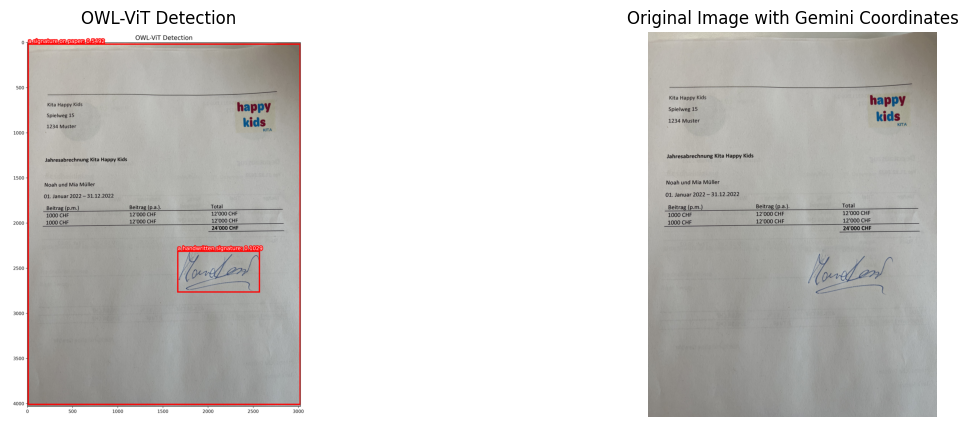

In [51]:
from PIL import Image  # Für Bildverarbeitung
import matplotlib.pyplot as plt  # Für Visualisierung
import matplotlib.patheffects as pe  # Für Text-Effekte bei Annotationen
from transformers import pipeline  # Für OWL-ViT
import google.generativeai as genai  # Für Gemini
import os  # Für Umgebungsvariablen

def compare_detections(image_path):
    # 1. Bild laden
    image = Image.open(image_path)  # Öffnet das Bild, das analysiert werden soll

    # 2. OWL-ViT Detektion
    def preprocess_outputs(output):
        """
        Verarbeitet die Ausgaben von OWL-ViT, um sie für die Visualisierung vorzubereiten.
        """
        input_scores = [x["score"] for x in output]  # Extrahiert die Detektions-Scores
        input_labels = [x["label"] for x in output]  # Extrahiert die Labels
        input_boxes = []
        for i in range(len(output)):
            input_boxes.append([*output[i]["box"].values()])  # Extrahiert die Koordinaten
        input_boxes = [input_boxes]
        return input_scores, input_labels, input_boxes

    def show_box(box, ax):
        """
        Zeichnet eine Bounding-Box auf das Bild.
        """
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(
            plt.Rectangle((x0, y0), w, h, edgecolor="red", facecolor="none", lw=3)
        )

    def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores, title):
        """
        Visualisiert Bounding-Boxen, Labels und Scores auf dem Bild.
        """
        plt.figure(figsize=(15, 15))
        plt.imshow(raw_image)
        for i, box in enumerate(boxes):
            show_box(box, plt.gca())  # Zeichnet Bounding-Box
            plt.text(
                x=box[0],
                y=box[1] - 12,
                s=f"{labels[i]}: {scores[i]:,.4f}",  # Label und Score anzeigen
                c="white",
                path_effects=[pe.withStroke(linewidth=4, foreground="red")],
                fontsize=12
            )
        plt.axis("on")
        plt.title(title, fontsize=14)
        plt.savefig(f'detected_objects_{title}.png', bbox_inches='tight', dpi=300)
        plt.close()

    # OWL-ViT Setup mit Textlabels
    OWL_checkpoint = "google/owlvit-base-patch32"  # Modell-Checkpoint
    text = [
        "a handwritten signature",
        "a signature on paper",
        "handwriting at bottom of document",
        "signed document"
    ]

    # OWL-ViT Modell initialisieren
    detector = pipeline(
        model=OWL_checkpoint,
        task="zero-shot-object-detection"
    )

    # OWL-ViT Detektion ausführen
    output_owl = detector(
        image,  # Eingabebild
        candidate_labels=text,  # Textlabels für die Detektion
        threshold=0.1  # Score-Schwelle
    )

    print("\nOWL-ViT Detection Results:")
    print(output_owl)

    # Ergebnisse von OWL-ViT visualisieren
    input_scores, input_labels, input_boxes = preprocess_outputs(output_owl)
    show_boxes_and_labels_on_image(
        image, input_boxes[0], input_labels, input_scores, "OWL-ViT Detection"
    )

    # 3. Gemini Detektion mit angepasstem Prompt
    genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))  # API-Schlüssel konfigurieren
    model = genai.GenerativeModel("gemini-1.5-pro")  # Gemini-Modell initialisieren

    response = model.generate_content([
        image,  # Eingabebild
        ("Detect if there is a handwritten signature on this document and return its coordinates as a list in the format '[ymin,xmin, ymax, xmax]'. Just output the list and draw a rectangle around the found caption to emphasise it from the text.\n")  # Prompt
    ])
    response.resolve()  # Antwort des Modells verarbeiten
    print("\nGemini Detection Results:")
    print(response.text)  # Antwort ausgeben

    # 4. Ergebnisse visualisieren
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open('detected_objects_OWL-ViT Detection.png'))  # OWL-ViT Ergebnis
    plt.title('OWL-ViT Detection')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)  # Originalbild mit Gemini-Koordinaten
    plt.title('Original Image with Gemini Coordinates')
    plt.axis('off')
    plt.show()

# Funktion für verschiedene Bilder ausführen
image_paths = ["images/example_signature.jpg"]  # Liste der Bilder, die analysiert werden sollen
for img_path in image_paths:
    print(f"\nProcessing image: {img_path}")
    compare_detections(img_path)



Processing optimized detection for: images/example_signature.jpg

Gemini Detection Results (Optimized):
I found a handwritten signature located at the following bounding box: [566,558,852,857].


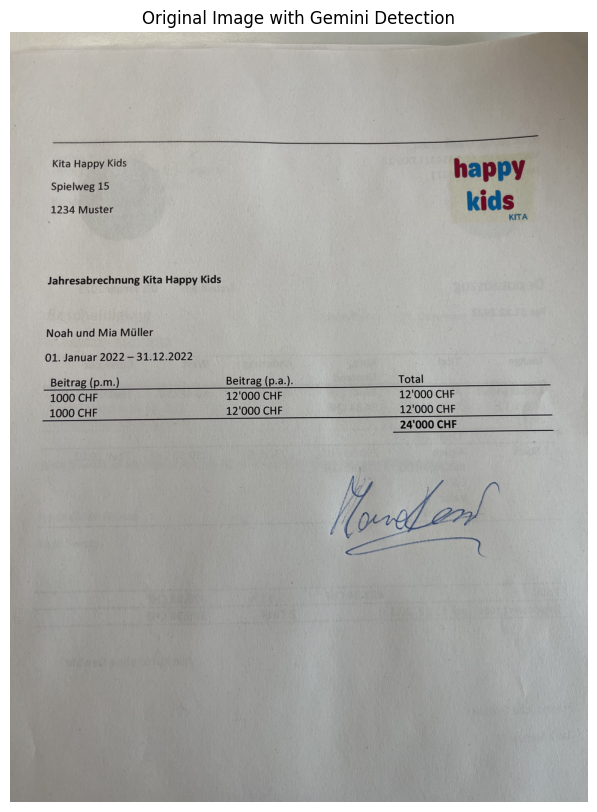

In [49]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import google.generativeai as genai

def compare_detections_with_bounding_box(image_path):
    # 1. Bild laden
    image = Image.open(image_path).convert("RGB")  # Sicherstellen, dass das Bild im RGB-Format vorliegt
    
    # 2. Gemini-API konfigurieren
    genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
    model = genai.GenerativeModel("gemini-1.5-pro")

    # 3. Präziserer Prompt für Gemini
    response = model.generate_content([
        image,
        (
            "Analyze this document image and detect if there is a handwritten signature. "
            "If a signature is found, return its coordinates as a list in the format '[ymin, xmin, ymax, xmax]'. "
            "Focus on the lower sections of the document where signatures are commonly located. "
            "Make sure to verify if the signature is handwritten."
        )
    ])
    response.resolve()
    print("\nGemini Detection Results (Optimized):")
    print(response.text)
    
    # 4. Koordinaten aus der Gemini-Antwort extrahieren
    try:
        bounding_box = eval(response.text.strip())  # Wandelt die Koordinatenliste in ein Python-Objekt um
        ymin, xmin, ymax, xmax = bounding_box  # Extrahiert die Werte
    except Exception as e:
        print(f"Error parsing coordinates: {e}")
        return

    # 5. Bounding Box zeichnen
    draw = ImageDraw.Draw(image)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)  # Zeichnet einen roten Rahmen um die Unterschrift

    # 6. Ergebnisse visualisieren
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title("Original Image with Detected Signature (Bounding Box)")
    plt.axis('off')
    plt.show()

# Pfad zum Bild
image_path = "images/example_signature.jpg"  # Hier das hochgeladene Bild verwenden
print(f"\nProcessing optimized detection for: {image_path}")
compare_detections_with_optimization(image_path)


Processing image: images/example_signature.jpg
Running OWL-ViT detection...

OWL-ViT Detection Results:
[{'score': 0.549213707447052, 'label': 'a signature on paper', 'box': {'xmin': 9, 'ymin': 17, 'xmax': 3019, 'ymax': 4009}}, {'score': 0.10286667943000793, 'label': 'a handwritten signature', 'box': {'xmin': 1664, 'ymin': 2312, 'xmax': 2568, 'ymax': 2763}}]


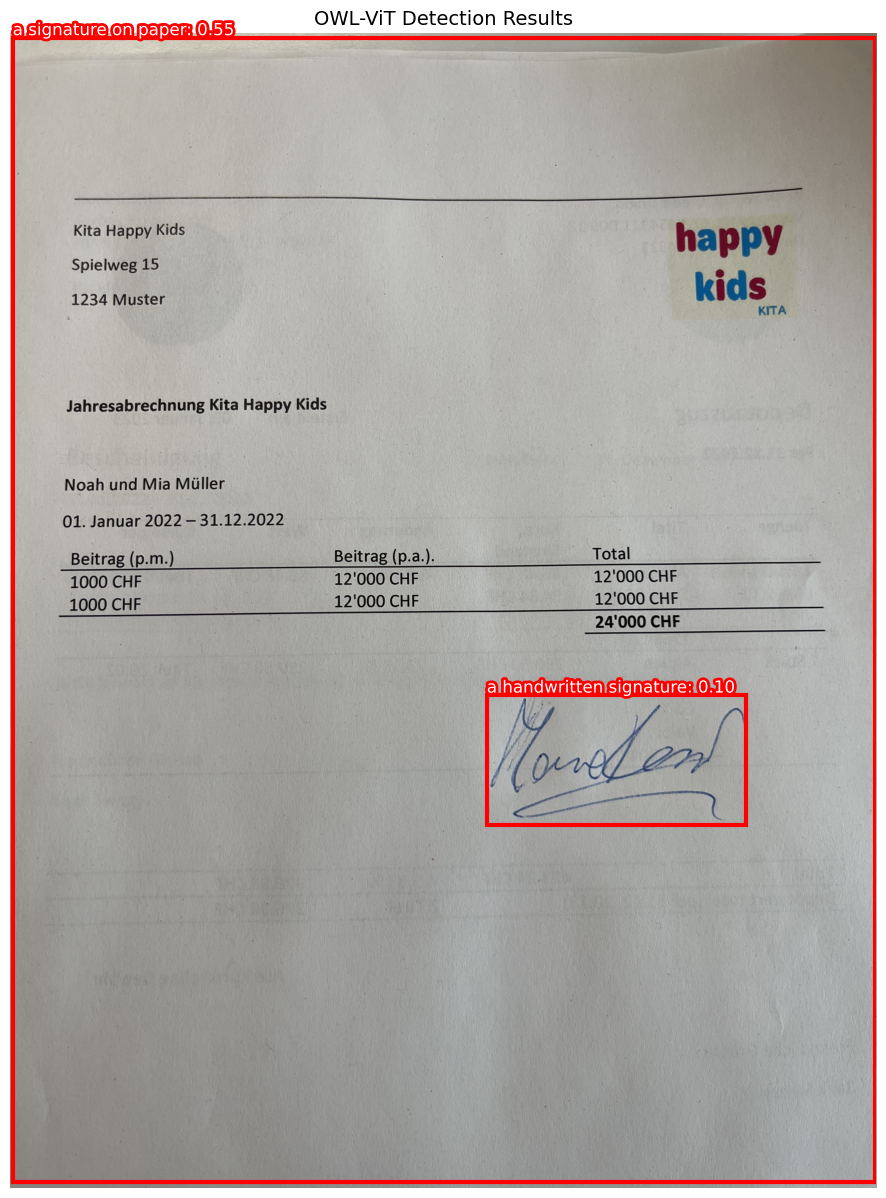

In [53]:
from PIL import Image  # Für Bildverarbeitung
import matplotlib.pyplot as plt  # Für Visualisierung
import matplotlib.patheffects as pe  # Für Text-Effekte bei Annotationen
from transformers import pipeline  # Für OWL-ViT

def detect_and_visualize_with_owlvit(image_path):
    # 1. Bild laden
    image = Image.open(image_path)  # Öffnet das Bild
    
    # 2. OWL-ViT Setup mit relevanten Labels
    OWL_checkpoint = "google/owlvit-base-patch32"  # Modell-Checkpoint
    text_labels = [
        "a handwritten signature",  # Handschriftliche Unterschrift
        "a signature on paper",  # Unterschrift auf Papier
        "handwriting at bottom of document",  # Handschrift am unteren Rand des Dokuments
        "signed document"  # Signiertes Dokument
    ]

    # OWL-ViT Modell initialisieren
    detector = pipeline(
        model=OWL_checkpoint,
        task="zero-shot-object-detection"
    )

    # 3. OWL-ViT Detektion durchführen
    print("Running OWL-ViT detection...")
    output_owl = detector(
        image,  # Eingabebild
        candidate_labels=text_labels,  # Textlabels für die Objekterkennung
        threshold=0.1  # Score-Schwelle für die Erkennung
    )
    
    # 4. Ergebnisse ausgeben
    print("\nOWL-ViT Detection Results:")
    print(output_owl)

    # 5. Ergebnisse vorbereiten
    def preprocess_outputs(output):
        """
        Extrahiert Scores, Labels und Bounding-Boxen aus der OWL-ViT-Ausgabe.
        """
        scores = [x["score"] for x in output]
        labels = [x["label"] for x in output]
        boxes = [list(x["box"].values()) for x in output]
        return scores, labels, boxes

    scores, labels, boxes = preprocess_outputs(output_owl)

    # 6. Ergebnisse visualisieren
    def show_boxes_and_labels_on_image(raw_image, boxes, labels, scores, title):
        """
        Zeichnet Bounding-Boxen, Labels und Scores auf das Bild.
        """
        plt.figure(figsize=(15, 15))
        plt.imshow(raw_image)
        for i, box in enumerate(boxes):
            x0, y0, x1, y1 = box
            plt.gca().add_patch(
                plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red", facecolor="none", lw=3)
            )
            plt.text(
                x=x0,
                y=y0 - 10,
                s=f"{labels[i]}: {scores[i]:.2f}",
                color="white",
                path_effects=[pe.withStroke(linewidth=4, foreground="red")],
                fontsize=12
            )
        plt.axis("off")
        plt.title(title, fontsize=14)
        plt.show()

    show_boxes_and_labels_on_image(
        image, boxes, labels, scores, "OWL-ViT Detection Results"
    )

# Funktion auf ein Beispielbild anwenden
image_path = "images/example_signature.jpg"  # Ersetze durch den Pfad zu deinem Bild
print(f"\nProcessing image: {image_path}")
detect_and_visualize_with_owlvit(image_path)


Wenn du aus einem anderen Bild etwas anderes extrahieren möchtest, müsstest du vor allem die **Textlabels** und eventuell den **Modell-Prompt** anpassen. Im Wesentlichen gibt es zwei Hauptstellen im Code, die geändert werden müssen:

---

### **1. Ändern der Textlabels**
Die Textlabels definieren, **was das Modell im Bild suchen soll**. Diese findest du in folgendem Abschnitt des Codes:

#### Aktueller Code:
```python
text_labels = [
    "a handwritten signature",  # Handschriftliche Unterschrift
    "a signature on paper",  # Unterschrift auf Papier
    "handwriting at bottom of document",  # Handschrift am unteren Rand des Dokuments
    "signed document"  # Signiertes Dokument
]
```

#### Was ändern?
Wenn du ein anderes Objekt oder Konzept suchen möchtest, ersetze die Labels durch neue, relevante Begriffe. Beispiele:

- Wenn du **Autos** in einem Bild finden möchtest:
  ```python
  text_labels = [
      "a car",
      "a red car",
      "a vehicle parked on the street",
      "a moving car"
  ]
  ```

- Wenn du **Tiere** wie Hunde erkennen möchtest:
  ```python
  text_labels = [
      "a dog",
      "a black dog",
      "a puppy sitting on grass",
      "a pet playing outside"
  ]
  ```

---

### **2. Anpassen des `threshold`-Werts**
Der `threshold`-Wert bestimmt die Mindestwahrscheinlichkeit, ab der ein erkannter Bereich berücksichtigt wird. Wenn du etwas sehr Spezifisches oder selten Erkennbares suchst, könnte es hilfreich sein, den Schwellenwert anzupassen:

#### Aktueller Code:
```python
threshold=0.1  # Score-Schwelle
```

#### Was ändern?
- **Für breitere Erkennung (mehr Treffer):** Setze den Wert niedriger, z. B. `0.05`.
- **Für präzisere Erkennung (weniger Treffer):** Setze den Wert höher, z. B. `0.3`.

---

### **3. Optional: Titel und Visualisierung anpassen**
Der Titel der Visualisierung sollte ebenfalls angepasst werden, damit er das neue Ziel der Erkennung beschreibt.

#### Aktueller Code:
```python
show_boxes_and_labels_on_image(
    image, boxes, labels, scores, "OWL-ViT Detection Results"
)
```

#### Was ändern?
Wenn du beispielsweise nach Autos suchst, kannst du den Titel so ändern:
```python
show_boxes_and_labels_on_image(
    image, boxes, labels, scores, "Detected Cars"
)
```

---

### **4. Andere Bildquelle verwenden**
Um ein anderes Bild zu analysieren, musst du den **Pfad zum Bild** ändern. Dies geschieht hier:

#### Aktueller Code:
```python
image_path = "image.png"  # Ersetze durch den tatsächlichen Bildpfad
```

#### Was ändern?
Ersetze `"image.png"` durch den Pfad zu deinem neuen Bild, z. B.:
```python
image_path = "images/car_street.jpg"
```

---

### **Zusammenfassung: Was genau ändern?**
Wenn du etwas anderes extrahieren möchtest:
1. **Textlabels ändern**: Beschreibe, was du erkennen möchtest.
2. **Threshold anpassen**: Erhöhe oder senke die Wahrscheinlichkeitsschwelle.
3. **Bildquelle ändern**: Nutze ein anderes Bild, indem du den Bildpfad ersetzt.
4. **Visualisierungstitel ändern**: Passe den Titel entsprechend dem neuen Ziel an.

Falls du ein Beispiel für eine spezifische Anwendung möchtest, lass es mich wissen, und ich passe den Code entsprechend an!

Gemini can be used to predict bounding boxes based on free form text queries.
The model can be prompted to return the boxes in a variety of different formats (dictionary, list, etc). This of course migh need to be parsed. 
Check: https://colab.research.google.com/drive/1eDvf_Ky9jLOZFShgHrm4GI-wkAaQnue6?usp=sharing#scrollTo=WFLDgSztv77H
